In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sensr import calc_sensitive_directions, compl_svd_projector, unprotected_direction
from sensr import normalize_sensitive_directions, sample_perturbation, sample_perturbation

from models import MLP
from training import train_classifier

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def gen_synth_data(ds_size=6000):
    pr_priv_fav=0.1
    pr_unpriv_fav=1 - pr_priv_fav
    
    n_priv_fav = int((ds_size//2) * pr_priv_fav)
    n_unpriv_fav =int((ds_size//2) * pr_unpriv_fav)
    n_priv_unfav = int((ds_size//2) * (1-pr_priv_fav))
    n_unpriv_unfav = int((ds_size//2) * (1-pr_unpriv_fav))
  
     
    x_priv_fav = torch.cat([torch.normal(mean=1, std=1, size=(n_priv_fav, 1)), torch.ones(n_priv_fav, 1)], dim=1)
    x_unpriv_fav = torch.cat([torch.normal(mean=1, std=1, size=(n_unpriv_fav, 1)), torch.zeros(n_unpriv_fav, 1)], dim=1)
    
    x_priv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_priv_unfav, 1)), torch.ones(n_priv_unfav, 1)], dim=1)
    x_unpriv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_unpriv_unfav, 1)), torch.zeros(n_unpriv_unfav, 1)], dim=1)
    
    synth_inputs = torch.cat((x_priv_fav, x_unpriv_fav, x_priv_unfav, x_unpriv_unfav), dim=0)
    synth_labels = torch.cat( (torch.ones(n_priv_fav + n_unpriv_fav), torch.zeros(n_priv_unfav + n_unpriv_unfav)), dim=0)
    synth_metas = torch.cat( (torch.ones(n_priv_fav), torch.zeros(n_unpriv_fav), torch.ones(n_priv_unfav), torch.zeros(n_unpriv_unfav)), dim=0)
    
    return synth_inputs, synth_labels, synth_metas

In [4]:
x, y, s = gen_synth_data()

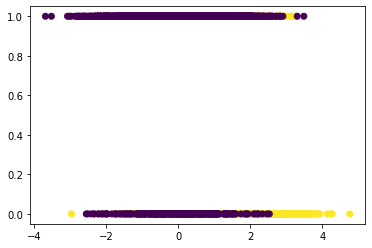

In [5]:
plt.scatter(x[:,0], x[:,1], c=y)

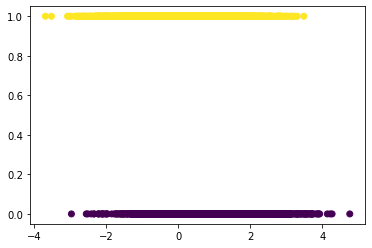

In [6]:
plt.scatter(x[:,0], x[:,1], c=s)

In [7]:
sensitive_directions = calc_sensitive_directions(x.numpy(), s.numpy())
sensitive_directions

array([[-0.22035346, 15.18567678]])

In [8]:
sensitive_directions_ = normalize_sensitive_directions(sensitive_directions.T)
sensitive_directions_

array([[ 2.10513529e-04, -1.45075571e-02],
       [-1.45075571e-02,  9.99789486e-01]])

In [9]:
proj = compl_svd_projector(sensitive_directions)
proj

array([[9.99789486e-01, 1.45075571e-02],
       [1.45075571e-02, 2.10513529e-04]])

In [10]:
xp = unprotected_direction(x, sensitive_directions_)

In [11]:
x.shape, xp.shape

(torch.Size([5999, 2]), torch.Size([5999, 2]))

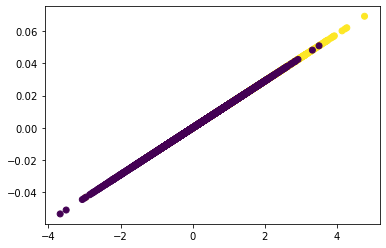

In [12]:
plt.scatter(xp[:,0], xp[:,1], c=y)

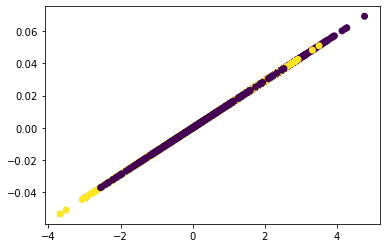

In [13]:
plt.scatter(xp[:,0], xp[:,1], c=s)

In [14]:
batch_size = 128

dataset = TensorDataset(x.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [15]:
model = MLP(2, [10, 10], 2)

In [16]:
optimizer_clf = optim.Adam(model.parameters(), lr=0.005)
loss_criterion = torch.nn.CrossEntropyLoss()

In [17]:
model = train_classifier(model, optimizer_clf, loader, loss_criterion, 20, "cpu")

Average Clf epoch loss: 0.2855016402107604: 100%|██████████████████████████████████████| 20/20 [00:03<00:00,  6.39it/s]

Average Clf batch loss:  0.3016930599161919


In [18]:
yh = model(x)
np.mean(yh.detach().numpy().argmax(-1) == y.numpy())

0.9029838306384398

In [19]:
modelp = MLP(2, [10, 10], 2)

In [20]:
optimizer_clf = optim.Adam(modelp.parameters(), lr=0.005)
modelp = train_classifier(modelp, optimizer_clf, loader, loss_criterion, 20, "cpu")

Average Clf epoch loss: 0.2864726166775886: 100%|██████████████████████████████████████| 20/20 [00:03<00:00,  5.82it/s]

Average Clf batch loss:  0.29817870587427564


In [21]:
yh = modelp(x)
np.mean(yh.detach().numpy().argmax(-1) == y.numpy())

0.9026504417402901

In [22]:
xp = sample_perturbation(model, x, y.long(), torch.FloatTensor(sensitive_directions_), learning_rate=1, num_steps=1000, regularizer=100)

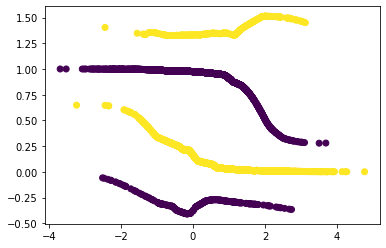

In [23]:
plt.scatter(xp[:,0].detach().numpy(), xp[:,1].detach().numpy(), c=y)

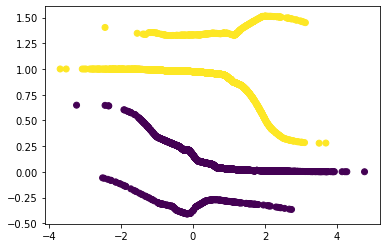

In [24]:
plt.scatter(xp[:,0].detach().numpy(), xp[:,1].detach().numpy(), c=s)